In [47]:
import pandas as pd
import numpy as np

## Homework part 2 Linear Regression

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


### Dataset

In this homework, we will use the Laptops price dataset from [Kaggle](https://www.kaggle.com/datasets/juanmerinobermejo/laptops-price-dataset).

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
```

The goal of this homework is to create a regression model for predicting the prices (column `'Final Price'`).



In [ ]:
! wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

In [48]:
df = pd.read_csv("laptops.csv")

In [49]:
# make better colnames
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   laptop        2160 non-null   object 
 1   status        2160 non-null   object 
 2   brand         2160 non-null   object 
 3   model         2160 non-null   object 
 4   cpu           2160 non-null   object 
 5   ram           2160 non-null   int64  
 6   storage       2160 non-null   int64  
 7   storage_type  2118 non-null   object 
 8   gpu           789 non-null    object 
 9   screen        2156 non-null   float64
 10  touch         2160 non-null   object 
 11  final_price   2160 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 202.6+ KB


### Preparing the dataset 

First, we'll normalize the names of the columns:

```python
df.columns = df.columns.str.lower().str.replace(' ', '_')
```

Now, instead of `'Final Price'`, we have `'final_price'`.

Next, use only the following columns:

* `'ram'`,
* `'storage'`,
* `'screen'`,
* `'final_price'`

### EDA

* Look at the `final_price` variable. Does it have a long tail? 

It seems to have.

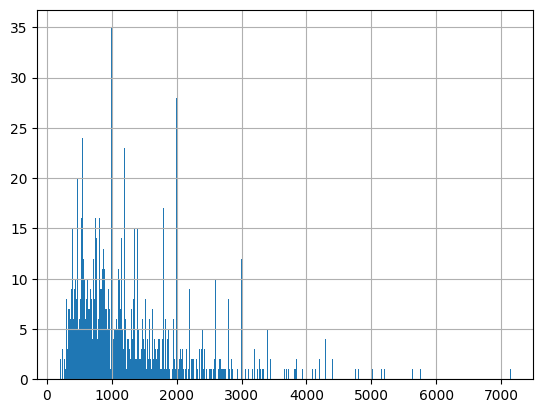

In [50]:
df.final_price.hist(bins = 1000);

### Question 1

There's one column with missing values. What is it?

* `'ram'`
* `'storage'`
* `'screen'`
* `'final_price'`

We can see from info() that screen has some null values.

### Question 2

What's the median (50% percentile) for variable `'ram'`?

- 8
- 16
- 24
- 32

In [51]:
df.ram.median()

np.float64(16.0)

### Prepare and split the dataset

* Shuffle the dataset (the filtered one you created above), use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.

Use the same code as in the lectures




In [52]:
# shuffle the dataset as in lectures
np.random.seed(42)

n = len(df)

# 20% val, 20% test, 60% train
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

### Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

Options:

- With 0
- With mean
- Both are equally good


In [53]:
df.describe()

,ram,storage,screen,final_price
count,2160.000000,2160.000000,2156.000000,2160.000000
mean,15.413889,596.294444,15.168112,1312.638509
std,9.867815,361.220506,1.203329,911.475417
min,4.000000,0.000000,10.100000,201.050000
25%,8.000000,256.000000,14.000000,661.082500
50%,16.000000,512.000000,15.600000,1031.945000
75%,16.000000,1000.000000,15.600000,1708.970000
max,128.000000,4000.000000,18.000000,7150.470000


### Linear regression with matrix multiplication

We use analytical solution for LR! :-D


In [54]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X]) #stack 1D arrays as columns in 2D array

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:] #return weights (coefficients)

In [55]:
# 1. filling missing values with 0 (should be worse because it is screen diameter)
# use code from the lecture
base = ["ram", "storage", "screen"]

def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [56]:
# get the coefs
X_train = prepare_X(df_train)
y_train = df_train.final_price.values
w_0, w = train_linear_regression(X_train, y_train)

In [57]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [58]:
# check rmse on val set
X_val = prepare_X(df_val)
y_val = df_val.final_price.values
y_pred = w_0 + X_val.dot(w)

round(rmse(y_val, y_pred),2)

np.float64(597.36)

In [59]:
# 2. Replacing with mean
mymean = df_train.screen.mean(skipna=True)

def prepare_X_mean(df):
    df_num = df[base]
    #df_num = df_num.fillna(0)
    df_num = df_num.fillna({"screen": mymean})
    X = df_num.values
    return X

X_train = prepare_X_mean(df_train)

In [60]:
# retrain model
w_0, w = train_linear_regression(X_train, y_train)

In [61]:
# predict on val set
X_val = prepare_X_mean(df_val)

y_pred = w_0 + X_val.dot(w)

# rmse
round(rmse(y_val, y_pred) ,2)

np.float64(600.27)

With mean is actually worse, interesting!

### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.01, 0.1, 1, 5, 10, 100]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

Options:

- 0
- 0.01
- 1
- 10
- 100


In [62]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [63]:
# again fill with 0
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

In [64]:
# loop over r
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    # train the model
    w_0, w = train_linear_regression_reg(X_train, y_train, r)
    # evaluate on validation set
    y_pred = w_0 + X_val.dot(w)
    print(f'r: {r}, rmse: {round(rmse(y_val, y_pred) ,2)}')

r: 0, rmse: 597.36
r: 0.01, rmse: 597.36
r: 0.1, rmse: 597.35
r: 1, rmse: 597.21
r: 5, rmse: 597.01
r: 10, rmse: 597.06
r: 100, rmse: 597.9


r=5 is best.

### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

What's the value of std?

- 19.176
- 29.176
- 39.176
- 49.176

> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.


In [65]:
def split_data(df, seed = 42):
    np.random.seed(seed)

    n = len(df)

    # 20% val, 20% test, 60% train
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    
    return df_train, df_val, df_test

In [67]:
# loop over seeds
scores = []
for seed in range(10):
    print(f'processing step {seed}') #monitor
    df_train, df_val, df_test = split_data(df, seed)
    X_train = prepare_X(df_train)
    y_train = df_train.final_price.values
    X_val = prepare_X(df_val)
    y_val = df_val.final_price.values
    w_0, w = train_linear_regression(X_train, y_train)
    y_pred = w_0 + X_val.dot(w)
    scores.append(rmse(y_val, y_pred))

processing step 0
processing step 1
processing step 2
processing step 3
processing step 4
processing step 5
processing step 6
processing step 7
processing step 8
processing step 9


In [68]:
round(np.std(scores),3)

np.float64(29.176)

### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

Options:

- 598.60
- 608.60
- 618.60
- 628.60



In [72]:
# split the dataset with seed 9
df_train, df_val, df_test = split_data(df, seed=9)
# combine train and validation (why didn't we just split into 2 in the first place?)
df_trainval = pd.concat([df_train, df_val])
# use prepare_X to fill na with 0
X_train = prepare_X(df_trainval)
y_train = df_trainval.final_price.values
# train with regularization 0.001
w_0, w = train_linear_regression_reg(X_train, y_train, 0.001)
# calculate rmse on test set
X_test = prepare_X(df_test)
y_test = df_test.final_price.values
y_pred = w_0 + X_test.dot(w)
round(rmse(y_test, y_pred),2)

np.float64(608.61)

## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2024/homework/hw02
* If your answer doesn't match options exactly, select the closest one
